In [1]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
from ultralytics import YOLOWorld
model=YOLOWorld('yolov8s-worldv2.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 24.7M/24.7M [00:00<00:00, 51.1MB/s]


In [3]:
# Download Pascal VOC dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar
!mkdir -p data/VOC/images
!mkdir -p data/VOC/annotations
!cp -r VOCdevkit/VOC2012/JPEGImages/* data/VOC/images/

--2025-04-19 17:38:06--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  10.3MB/s    in 1m 56s  

2025-04-19 17:40:02 (16.5 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [4]:
import os

# Paths
base_path = "/content"
voc_img_dir = f"{base_path}/data/VOC/images"
voc_anno_dir = f"{base_path}/VOCdevkit/VOC2012/ImageSets/Main"

# Helper to generate list of paths
def create_split_txt(split_name):
    split_file = f"{voc_anno_dir}/{split_name}.txt"
    out_file = f"{base_path}/{split_name}.txt"

    with open(split_file, "r") as f:
        image_ids = [line.strip() for line in f.readlines()]

    with open(out_file, "w") as f:
        for image_id in image_ids:
            f.write(f"{voc_img_dir}/{image_id}.jpg\n")

    print(f"✅ Created {out_file} with {len(image_ids)} entries.")

# Generate train.txt and val.txt
create_split_txt("train")
create_split_txt("val")

✅ Created /content/train.txt with 5717 entries.
✅ Created /content/val.txt with 5823 entries.


In [5]:
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Define class names from VOC
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Map class name to index
class_to_index = {cls: i for i, cls in enumerate(VOC_CLASSES)}

# Directories
images_dir = '/content/data/VOC/images'
annotations_dir = '/content/VOCdevkit/VOC2012/Annotations'
labels_dir = '/content/data/VOC/labels'
os.makedirs(labels_dir, exist_ok=True)

# Read all annotation files
ann_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]
print(f"Found {len(ann_files)} annotation files.")

def convert_voc_to_yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_id = root.find('filename').text.split('.')[0]
    size = root.find('size')
    w, h = int(size.find('width').text), int(size.find('height').text)

    label_lines = []

    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in class_to_index:
            continue
        cls_id = class_to_index[cls]

        xml_box = obj.find('bndbox')
        b = (
            float(xml_box.find('xmin').text),
            float(xml_box.find('xmax').text),
            float(xml_box.find('ymin').text),
            float(xml_box.find('ymax').text)
        )
        # YOLO format: x_center, y_center, width, height (normalized)
        x_center = ((b[0] + b[1]) / 2.0) / w
        y_center = ((b[2] + b[3]) / 2.0) / h
        width = (b[1] - b[0]) / w
        height = (b[3] - b[2]) / h

        label_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return image_id, label_lines

# Convert all annotations
for xml_file in ann_files:
    xml_path = os.path.join(annotations_dir, xml_file)
    image_id, label_lines = convert_voc_to_yolo(xml_path)
    if label_lines:
        with open(f"{labels_dir}/{image_id}.txt", "w") as f:
            f.write("\n".join(label_lines))


Found 17125 annotation files.


In [17]:
import glob

# Adjust as needed
image_dir = '/content/data/VOC/images'
image_paths = sorted(glob.glob(f'{image_dir}/*.jpg'))

# Split into train and val (e.g., 90/10 split)
split_index = int(len(image_paths) * 0.9)
train_paths = image_paths[:split_index]
val_paths = image_paths[split_index:]

# Save the new train.txt and val.txt
with open('/content/train.txt', 'w') as f:
    f.write('\n'.join(train_paths))
with open('/content/val.txt', 'w') as f:
    f.write('\n'.join(val_paths))

print("✅ New train.txt and val.txt created.")


✅ New train.txt and val.txt created.


In [18]:
results = model.train(data='/content/voc.yaml', epochs=30, imgsz=640)

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s-worldv2.pt, data=/content/voc.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

train: Scanning /content/data/VOC/labels... 5026 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5026/5026 [00:02<00:00, 2079.23it/s]

train: New cache created: /content/data/VOC/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 319.9±192.7 MB/s, size: 99.2 KB)


val: Scanning /content/data/VOC/labels... 559 images, 0 backgrounds, 0 corrupt: 100%|██████████| 559/559 [00:00<00:00, 1214.53it/s]

val: New cache created: /content/data/VOC/labels.cache


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 67 weight(decay=0.0), 72 weight(decay=0.0005), 81 bias(decay=0.0)


100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 43.9MiB/s]


Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train10
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.75G     0.7537      1.092      1.124         12        640: 100%|██████████| 315/315 [03:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]

                   all        559        724      0.765      0.812      0.862      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.21G     0.7881     0.9427      1.136          4        640: 100%|██████████| 315/315 [03:06<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.23it/s]

                   all        559        724      0.782      0.762      0.835      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.25G     0.8367      1.032      1.171          5        640: 100%|██████████| 315/315 [03:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.21it/s]

                   all        559        724      0.756      0.796      0.845      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.28G     0.8781      1.067      1.196         14        640: 100%|██████████| 315/315 [02:59<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

                   all        559        724      0.755      0.775      0.822      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.33G     0.8575       1.04      1.187          7        640: 100%|██████████| 315/315 [02:58<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

                   all        559        724      0.727      0.789      0.824      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.38G     0.8512      1.045      1.184          7        640: 100%|██████████| 315/315 [02:58<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.23it/s]

                   all        559        724      0.742      0.765      0.807      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.42G     0.8268     0.9876      1.169          4        640: 100%|██████████| 315/315 [02:59<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.14it/s]

                   all        559        724      0.758      0.783      0.826      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.42G     0.8336     0.9916      1.174          8        640: 100%|██████████| 315/315 [02:59<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.36it/s]

                   all        559        724      0.738      0.808      0.828      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.42G     0.8333     0.9961      1.175          4        640: 100%|██████████| 315/315 [02:58<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]

                   all        559        724      0.799      0.792      0.859      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.42G     0.8151     0.9467      1.164          6        640: 100%|██████████| 315/315 [03:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]

                   all        559        724      0.759      0.848      0.866      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.42G     0.8103     0.9142      1.151          9        640: 100%|██████████| 315/315 [02:59<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.39it/s]

                   all        559        724      0.797       0.78       0.86      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.42G     0.7855     0.9011      1.142          6        640: 100%|██████████| 315/315 [02:59<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.25it/s]

                   all        559        724      0.777      0.796      0.858      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.42G     0.7709     0.8694      1.129         12        640: 100%|██████████| 315/315 [02:58<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]

                   all        559        724      0.755      0.807      0.848      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.42G     0.7558     0.8488      1.116         13        640: 100%|██████████| 315/315 [02:59<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]

                   all        559        724      0.782       0.79       0.86      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.42G     0.7419     0.8358      1.117          8        640: 100%|██████████| 315/315 [02:59<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]

                   all        559        724      0.765      0.822      0.866       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.42G     0.7277     0.7938      1.104          4        640: 100%|██████████| 315/315 [02:59<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.22it/s]

                   all        559        724      0.751      0.806      0.851      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.42G     0.7332     0.7904      1.106          7        640: 100%|██████████| 315/315 [02:59<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.24it/s]

                   all        559        724      0.805      0.749      0.868      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.42G     0.7089     0.7583      1.091          6        640: 100%|██████████| 315/315 [02:59<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.33it/s]

                   all        559        724      0.736       0.84       0.86      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.42G     0.6941     0.7451      1.085          3        640: 100%|██████████| 315/315 [02:59<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.36it/s]

                   all        559        724      0.768      0.831      0.872      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.42G      0.686     0.7219      1.078          3        640: 100%|██████████| 315/315 [03:00<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.35it/s]

                   all        559        724      0.763      0.849      0.877      0.696


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.42G     0.6068     0.5926      1.014          5        640: 100%|██████████| 315/315 [02:58<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.25it/s]

                   all        559        724      0.807      0.805      0.874      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.42G     0.5769     0.5377     0.9892          5        640: 100%|██████████| 315/315 [02:56<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]

                   all        559        724      0.771      0.843      0.872      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.42G      0.562     0.5135     0.9893          6        640: 100%|██████████| 315/315 [02:56<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]

                   all        559        724      0.777      0.819      0.869      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.42G     0.5519     0.4967     0.9803          2        640: 100%|██████████| 315/315 [02:56<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

                   all        559        724      0.796      0.811      0.869      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.42G     0.5374     0.4833     0.9694          6        640: 100%|██████████| 315/315 [02:56<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]

                   all        559        724      0.768      0.848      0.869      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.42G     0.5353     0.4628     0.9674          5        640: 100%|██████████| 315/315 [02:57<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.26it/s]

                   all        559        724      0.768      0.865      0.873      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.42G     0.5151     0.4423     0.9502          2        640: 100%|██████████| 315/315 [02:56<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]

                   all        559        724      0.764      0.854      0.865      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.42G     0.5089     0.4261     0.9489          2        640: 100%|██████████| 315/315 [02:56<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]

                   all        559        724      0.797      0.837      0.874      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.42G     0.4961     0.4093     0.9375          5        640: 100%|██████████| 315/315 [02:56<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]

                   all        559        724       0.76      0.868      0.868      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.42G     0.4926     0.4021     0.9373          2        640: 100%|██████████| 315/315 [02:57<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        559        724      0.771      0.853       0.87      0.721



30 epochs completed in 1.547 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 25.8MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 25.8MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-worldv2 summary (fused): 87 layers, 12,749,288 parameters, 0 gradients, 36.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.56it/s]


                   all        559        724      0.797      0.836      0.874      0.723
                person        559        724      0.797      0.836      0.874      0.723
Speed: 0.3ms preprocess, 4.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train10


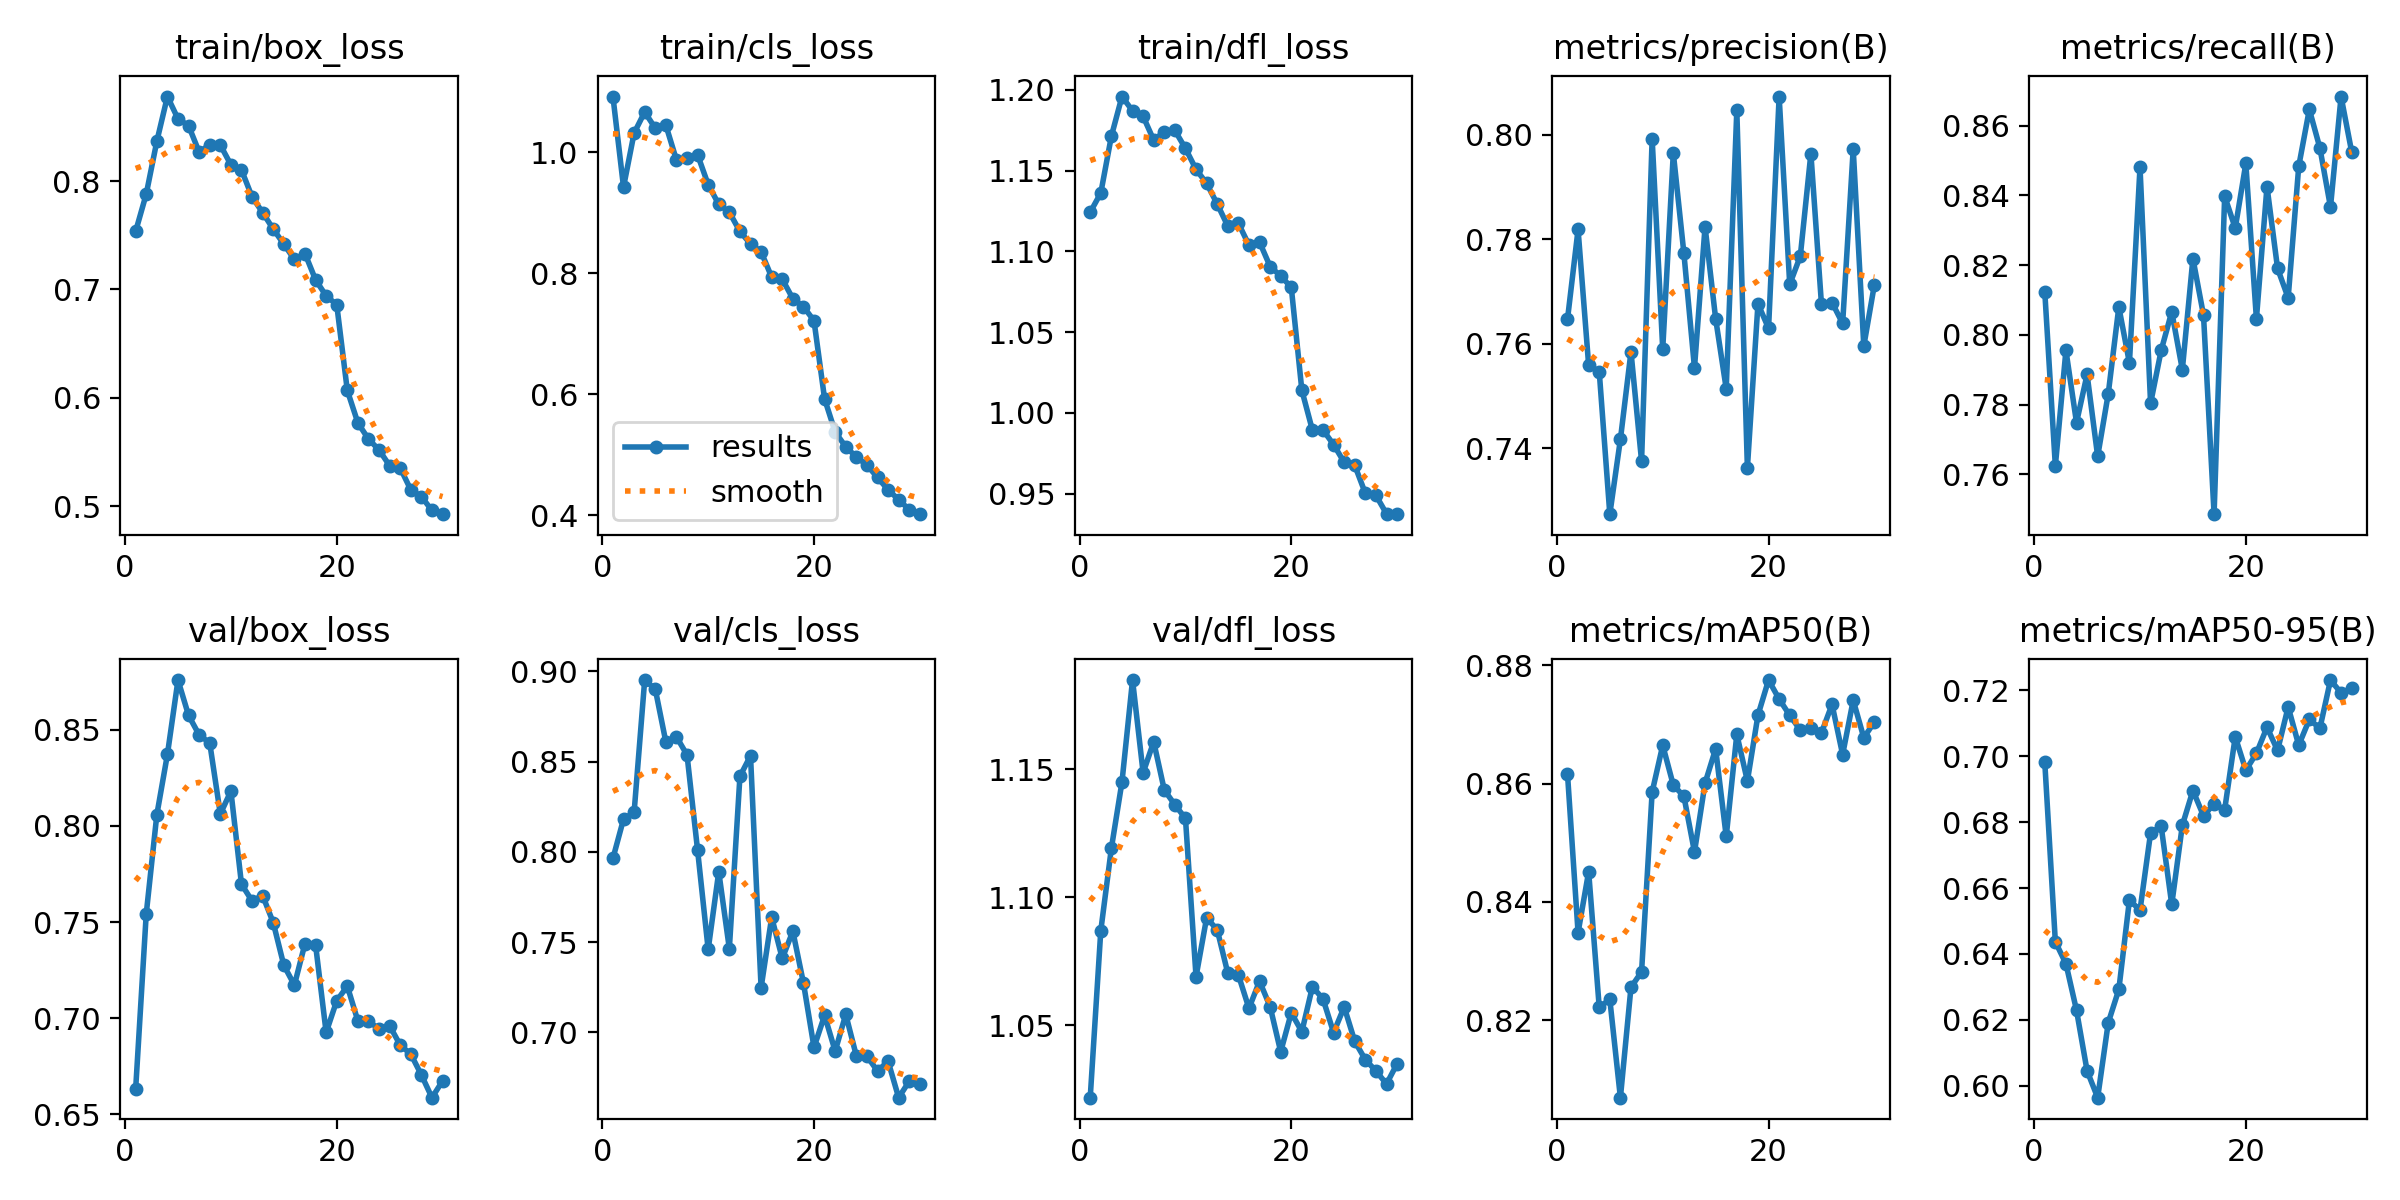

In [20]:
from IPython.display import Image, display

# Path to the results image
results_path = "runs/detect/train10/results.png"

# Display the image
display(Image(filename=results_path))

In [22]:
from ultralytics import YOLO

model = YOLO("runs/detect/train10/weights/best.pt")  # Load the best trained model
results = model.predict(source="/content/bus.jpg", show=True)  # You can also use an image URL


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()




FileNotFoundError: /content/bus.jpg does not exist

In [23]:
metrics = model.val()  # runs on val split from voc.yaml

Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1442.1±543.1 MB/s, size: 88.0 KB)


val: Scanning /content/data/VOC/labels.cache... 559 images, 0 backgrounds, 0 corrupt: 100%|██████████| 559/559 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]


                   all        559        724      0.798      0.837      0.875      0.724
                person        559        724      0.798      0.837      0.875      0.724
Speed: 0.9ms preprocess, 8.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


In [26]:
print(metrics.box.map)         # mAP@0.5
print(metrics.box.map50)       # mAP@0.5
print(metrics.box.map75)       # mAP@0.75
print(metrics.box.maps)        # list of class-wise mAPs


0.7240811657508751
0.8745593131627452
0.7696471133542597
[    0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408     0.72408]


In [27]:
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")


mAP@0.5: 0.8746
mAP@0.5:0.95: 0.7241


In [29]:
import os
import cv2
import torch
from tqdm import tqdm
from ultralytics import YOLO
from ultralytics.utils.metrics import bbox_iou

# Load the model
model = YOLO("runs/detect/train10/weights/best.pt")

# Read validation image paths from val.txt
val_txt_path = "/content/val.txt"  # update if yours is elsewhere
with open(val_txt_path, "r") as f:
    image_files = [line.strip() for line in f.readlines()]

# Initialize counters
TP, FP, FN = 0, 0, 0
ious = []

for image_path in tqdm(image_files, desc="Evaluating..."):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        continue
    img_h, img_w = img.shape[:2]

    # Run detection
    results = model.predict(source=img, conf=0.25, iou=0.45, verbose=False)
    pred_boxes = results[0].boxes.xyxy.cpu().numpy()

    # Load ground truth boxes from label file
    label_path = image_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")
    if not os.path.exists(label_path):
        continue

    with open(label_path, 'r') as f:
        gt_boxes = []
        for line in f.readlines():
            class_id, cx, cy, w, h = map(float, line.strip().split())
            # Convert from YOLO to xyxy
            x1 = (cx - w / 2) * img_w
            y1 = (cy - h / 2) * img_h
            x2 = (cx + w / 2) * img_w
            y2 = (cy + h / 2) * img_h
            gt_boxes.append([x1, y1, x2, y2])

    gt_boxes_tensor = torch.tensor(gt_boxes)
    pred_boxes_tensor = torch.tensor(pred_boxes)

    matched_gt = set()
    for pred_box in pred_boxes_tensor:
        best_iou = 0
        best_gt_idx = -1
        for idx, gt_box in enumerate(gt_boxes_tensor):
            iou = bbox_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        if best_iou >= 0.5:
            if best_gt_idx not in matched_gt:
                TP += 1
                ious.append(best_iou.item())
                matched_gt.add(best_gt_idx)
            else:
                FP += 1  # duplicate detection
        else:
            FP += 1  # false positive

    FN += len(gt_boxes) - len(matched_gt)

# Metrics
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
fdr = FP / (TP + FP) if (TP + FP) > 0 else 0
mean_iou = sum(ious) / len(ious) if ious else 0

# Print results
print("\n--- Performance Metrics ---")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"False Detection Rate (FDR): {fdr:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")


Evaluating...: 100%|██████████| 559/559 [00:12<00:00, 46.02it/s]



--- Performance Metrics ---
True Positives (TP): 655
False Positives (FP): 294
False Negatives (FN): 69
Precision: 0.6902
Recall: 0.9047
F1-Score: 0.7830
False Detection Rate (FDR): 0.3098
Mean IoU: 0.9256


In [30]:
import time
import numpy as np

# --- Add these before the loop ---
total_time = 0
ble_list = []

# --- Modify your for-loop like this ---
for image_path in tqdm(image_files, desc="Evaluating..."):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        continue
    img_h, img_w = img.shape[:2]

    start_time = time.time()  # Start timing

    # Inference
    results = model.predict(source=img, conf=0.25, iou=0.45, verbose=False)
    pred_boxes = results[0].boxes.xyxy.cpu().numpy()

    total_time += time.time() - start_time  # Accumulate time

    # Ground Truth Boxes
    label_path = image_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")
    if not os.path.exists(label_path):
        continue

    with open(label_path, 'r') as f:
        gt_boxes = []
        for line in f.readlines():
            class_id, cx, cy, w, h = map(float, line.strip().split())
            x1 = (cx - w / 2) * img_w
            y1 = (cy - h / 2) * img_h
            x2 = (cx + w / 2) * img_w
            y2 = (cy + h / 2) * img_h
            gt_boxes.append([x1, y1, x2, y2])

    gt_boxes_tensor = torch.tensor(gt_boxes)
    pred_boxes_tensor = torch.tensor(pred_boxes)

    matched_gt = set()
    for pred_box in pred_boxes_tensor:
        best_iou = 0
        best_gt_idx = -1
        for idx, gt_box in enumerate(gt_boxes_tensor):
            iou = bbox_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        if best_iou >= 0.5:
            if best_gt_idx not in matched_gt:
                TP += 1
                ious.append(best_iou.item())
                matched_gt.add(best_gt_idx)

                # Bounding Box Localization Error
                gt_box = gt_boxes_tensor[best_gt_idx]
                ble = np.abs(pred_box.numpy() - gt_box.numpy()).mean()
                ble_list.append(ble)
            else:
                FP += 1
        else:
            FP += 1

    FN += len(gt_boxes) - len(matched_gt)

# --- After the loop: compute final metrics ---

num_images = len(image_files)
tp_time = total_time / num_images if num_images else 0
fps = 1 / tp_time if tp_time > 0 else 0
ble = sum(ble_list) / len(ble_list) if ble_list else 0

# Print final output
print("\n--- Extended Performance Metrics ---")
print(f"Processing Time per Image (Tp): {tp_time:.4f} seconds")
print(f"Frames Per Second (FPS): {fps:.2f}")
print(f"Bounding Box Localization Error (BLE): {ble:.4f}")


Evaluating...: 100%|██████████| 559/559 [00:11<00:00, 49.51it/s]


--- Extended Performance Metrics ---
Processing Time per Image (Tp): 0.0169 seconds
Frames Per Second (FPS): 59.29
Bounding Box Localization Error (BLE): 5.5697


Evaluating...: 100%|██████████| 5823/5823 [02:27<00:00, 39.40it/s]



Performance Metrics:
Mean IoU: 0.9073
Precision: 0.8642
Recall: 0.5131
F1 Score: 0.6439
False Detection Rate (FDR): 0.1358
Processing Time per Image (Tp): 19.37 ms
Frames Per Second (FPS): 51.63
Bounding Box Localization Error (BLE): 27.85


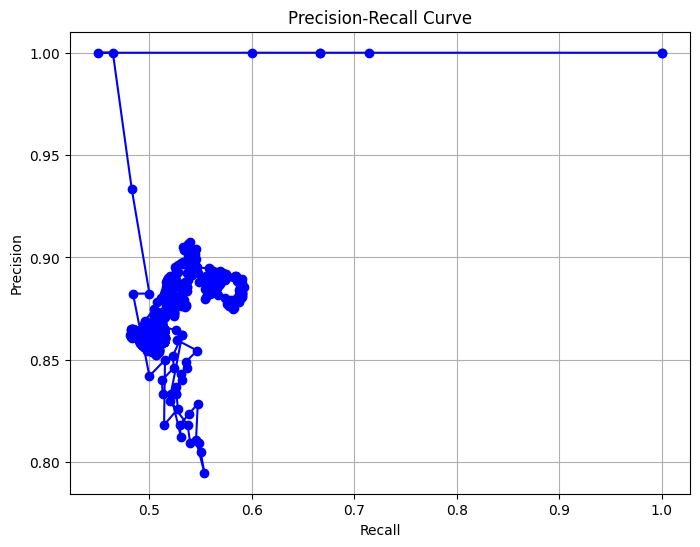

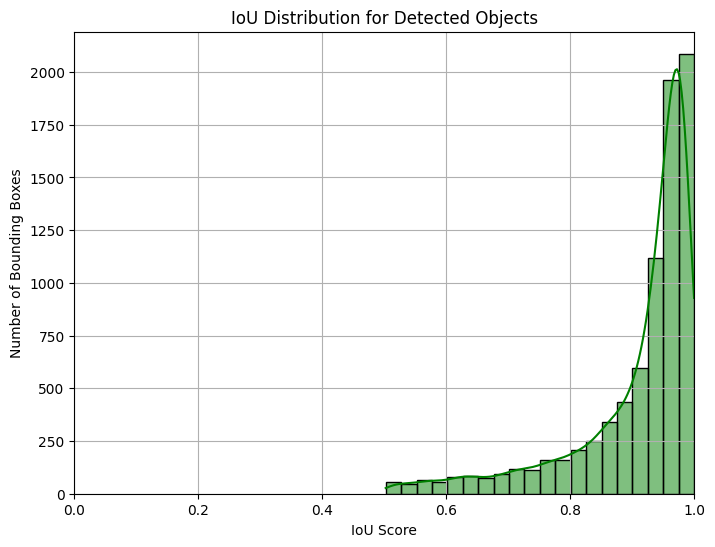

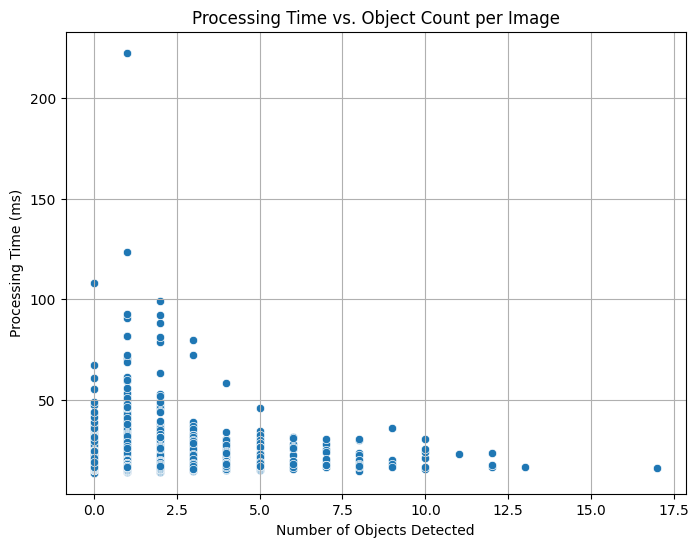

In [33]:
import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from ultralytics.utils.metrics import bbox_iou
from tqdm import tqdm

# Load model
model = YOLO("runs/detect/train10/weights/best.pt")

# Path to your dataset images and labels
val_img_path = "/content/data/VOC/images/val"
val_lbl_path = "/content/data/VOC/labels/val"

# Initialize metrics
TP = FP = FN = 0
ious_all = []
BLE_sum = 0
total_time = 0
total_images = 0

precisions = []
recalls = []
proc_times = []
obj_counts = []

# Loop through validation images
for file in tqdm(os.listdir(val_img_path), desc="Evaluating..."):
    if not file.endswith(('.jpg', '.png')): continue
    total_images += 1
    img_path = os.path.join(val_img_path, file)
    lbl_path = os.path.join(val_lbl_path, file.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Load ground truth
    with open(lbl_path, "r") as f:
        gt_data = [list(map(float, line.strip().split())) for line in f.readlines()]
    gt_boxes = []
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    for obj in gt_data:
        _, cx, cy, bw, bh = obj
        x1 = (cx - bw / 2) * w
        y1 = (cy - bh / 2) * h
        x2 = (cx + bw / 2) * w
        y2 = (cy + bh / 2) * h
        gt_boxes.append([x1, y1, x2, y2])

    # Prediction
    start = time.time()
    results = model.predict(source=img_path, conf=0.25, iou=0.45, verbose=False)
    end = time.time()

    pred_boxes = results[0].boxes.xyxy.cpu().numpy()
    pred_boxes_tensor = torch.tensor(pred_boxes)
    gt_boxes_tensor = torch.tensor(gt_boxes)

    elapsed = end - start
    total_time += elapsed
    proc_times.append(elapsed * 1000)  # ms
    obj_counts.append(len(pred_boxes))

    matched_gt = set()
    for pred_box in pred_boxes_tensor:
        best_iou = 0
        best_gt_idx = -1
        for idx, gt_box in enumerate(gt_boxes_tensor):
            iou = bbox_iou(pred_box, gt_box).item()
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        if best_iou >= 0.5:
            if best_gt_idx not in matched_gt:
                TP += 1
                ious_all.append(best_iou)
                matched_gt.add(best_gt_idx)
                BLE_sum += torch.sum(torch.abs(pred_box - gt_boxes_tensor[best_gt_idx])).item()
            else:
                FP += 1
        else:
            FP += 1

    FN += len(gt_boxes) - len(matched_gt)

    # Precision & Recall per image
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precisions.append(precision)
    recalls.append(recall)

# Final Metrics
IoU_mean = np.mean(ious_all) if ious_all else 0
Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0
FDR = FP / (TP + FP) if (TP + FP) > 0 else 0
Tp = (total_time / total_images) if total_images > 0 else 0
FPS = 1 / Tp if Tp > 0 else 0
BLE = BLE_sum / TP if TP > 0 else 0

# Print Results
print("\nPerformance Metrics:")
print(f"Mean IoU: {IoU_mean:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")
print(f"F1 Score: {F1:.4f}")
print(f"False Detection Rate (FDR): {FDR:.4f}")
print(f"Processing Time per Image (Tp): {Tp*1000:.2f} ms")
print(f"Frames Per Second (FPS): {FPS:.2f}")
print(f"Bounding Box Localization Error (BLE): {BLE:.2f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='o', color='blue')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# IoU Distribution
plt.figure(figsize=(8, 6))
sns.histplot(ious_all, bins=20, kde=True, color='green')
plt.title("IoU Distribution for Detected Objects")
plt.xlabel("IoU Score")
plt.ylabel("Number of Bounding Boxes")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

# Processing Time vs. Object Count per Image
plt.figure(figsize=(8, 6))
sns.scatterplot(x=obj_counts, y=proc_times, marker='o')
plt.title("Processing Time vs. Object Count per Image")
plt.xlabel("Number of Objects Detected")
plt.ylabel("Processing Time (ms)")
plt.grid(True)
plt.show()



Heatmap & BLE: 100%|██████████| 5823/5823 [02:14<00:00, 43.45it/s]


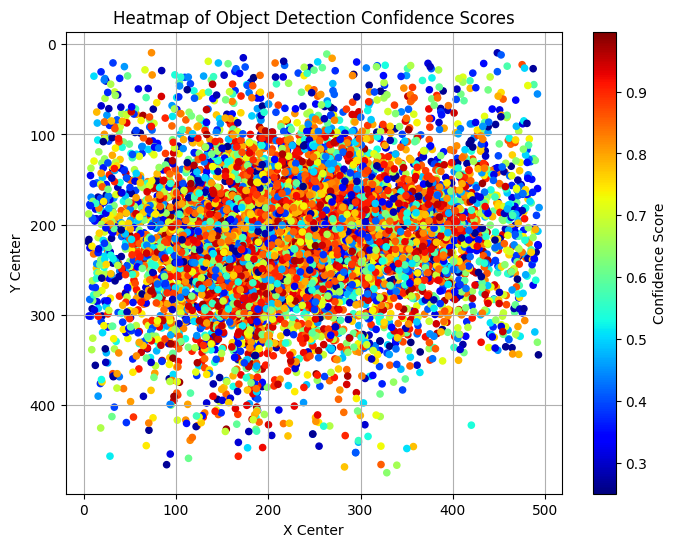

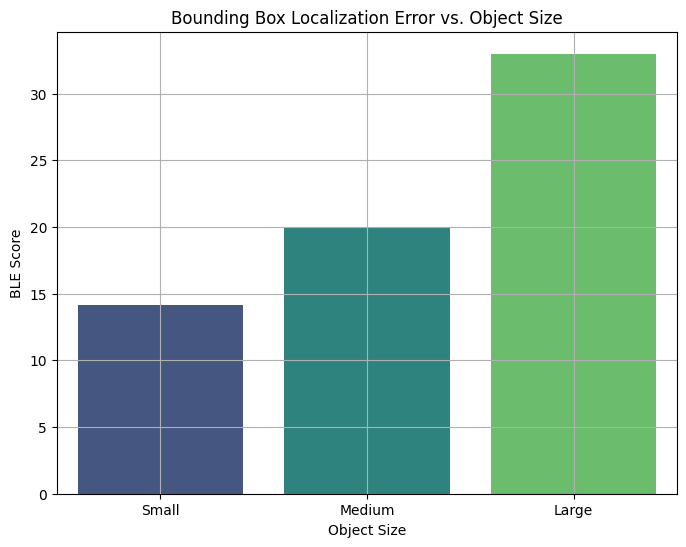

Evaluating FPS per Resolution: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


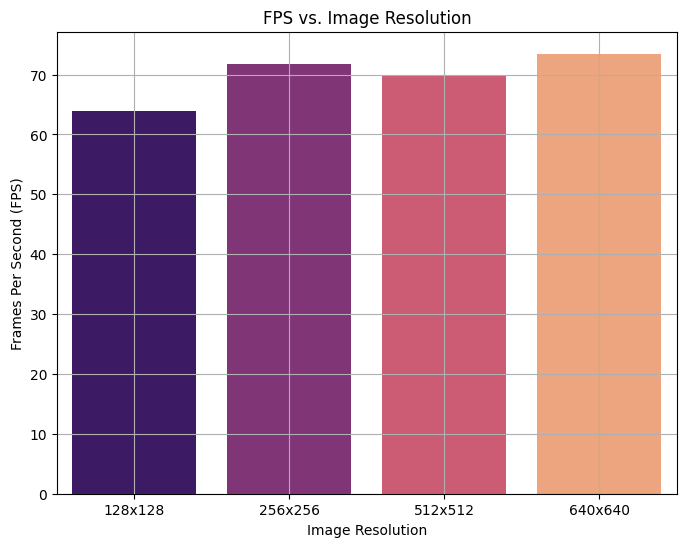

In [35]:
import cv2
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm
import os
import time

# Load trained model
model = YOLO("runs/detect/train10/weights/best.pt")

# Paths
val_img_path = "/content/data/VOC/images/val"
val_lbl_path = "/content/data/VOC/labels/val"

# Heatmap values
heat_confidences = []
heat_x = []
heat_y = []

# BLE vs Object Size
BLE_small, BLE_medium, BLE_large = [], [], []

# FPS vs Resolution
resolutions = [(128, 128), (256, 256), (512, 512), (640, 640)]
fps_results = []

# Loop for Heatmap & BLE vs Size
for file in tqdm(os.listdir(val_img_path), desc="Heatmap & BLE"):
    if not file.endswith(('.jpg', '.png')): continue

    img_path = os.path.join(val_img_path, file)
    lbl_path = os.path.join(val_lbl_path, file.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Read original image
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Ground Truth
    with open(lbl_path, "r") as f:
        gt_data = [list(map(float, line.strip().split())) for line in f.readlines()]
    gt_boxes = []
    for obj in gt_data:
        _, cx, cy, bw, bh = obj
        x1 = (cx - bw / 2) * w
        y1 = (cy - bh / 2) * h
        x2 = (cx + bw / 2) * w
        y2 = (cy + bh / 2) * h
        gt_boxes.append([x1, y1, x2, y2])
    gt_boxes = torch.tensor(gt_boxes)

    # Run prediction
    result = model.predict(source=img_path, conf=0.25, iou=0.45, verbose=False)[0]
    if result.boxes is None: continue

    boxes = result.boxes.xyxy.cpu()
    confs = result.boxes.conf.cpu().numpy()

    for i, box in enumerate(boxes):
        # For Heatmap
        x_center = (box[0] + box[2]) / 2
        y_center = (box[1] + box[3]) / 2
        heat_confidences.append(confs[i])
        heat_x.append(x_center.item())
        heat_y.append(y_center.item())

        # For BLE vs Object Size
        area = (box[2] - box[0]) * (box[3] - box[1])
        size = 'small' if area < 32**2 else 'medium' if area < 96**2 else 'large'

        best_iou = 0
        best_gt = None
        for gt_box in gt_boxes:
            iou = bbox_iou(box, gt_box).item()
            if iou > best_iou:
                best_iou = iou
                best_gt = gt_box
        if best_iou > 0.5 and best_gt is not None:
            ble = torch.sum(torch.abs(box - best_gt)).item()
            if size == 'small':
                BLE_small.append(ble)
            elif size == 'medium':
                BLE_medium.append(ble)
            else:
                BLE_large.append(ble)

# Plot Heatmap of Confidence Scores
plt.figure(figsize=(8, 6))
plt.scatter(heat_x, heat_y, c=heat_confidences, cmap='jet', s=20)
plt.colorbar(label='Confidence Score')
plt.title("Heatmap of Object Detection Confidence Scores")
plt.xlabel("X Center")
plt.ylabel("Y Center")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# BLE vs Object Size
sizes = ['Small', 'Medium', 'Large']
ble_means = [
    np.mean(BLE_small) if BLE_small else 0,
    np.mean(BLE_medium) if BLE_medium else 0,
    np.mean(BLE_large) if BLE_large else 0
]

plt.figure(figsize=(8, 6))
sns.barplot(x=sizes, y=ble_means, palette="viridis")
plt.title("Bounding Box Localization Error vs. Object Size")
plt.ylabel("BLE Score")
plt.xlabel("Object Size")
plt.grid(True)
plt.show()

# FPS vs Image Resolution
for res in tqdm(resolutions, desc="Evaluating FPS per Resolution"):
    img = np.random.randint(0, 255, (res[1], res[0], 3), dtype=np.uint8)
    num_trials = 20
    start = time.time()
    for _ in range(num_trials):
        _ = model.predict(img, verbose=False)
    end = time.time()
    avg_time = (end - start) / num_trials
    fps_results.append(1 / avg_time)

# Plot FPS vs. Resolution
res_labels = [f"{w}x{h}" for (w, h) in resolutions]
plt.figure(figsize=(8, 6))
sns.barplot(x=res_labels, y=fps_results, palette="magma")
plt.title("FPS vs. Image Resolution")
plt.xlabel("Image Resolution")
plt.ylabel("Frames Per Second (FPS)")
plt.grid(True)
plt.show()
